# Installations

In [5]:
!pip install gdown

In [2]:
!pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 

In [12]:
!pip install torch

In [23]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=0710f26f0462904f1c04b53e640b0769798a23b1d4c13c7ef7a0224a11aecc25
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


# Dataset Loading

In [6]:
!gdown --id 1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs --output dataset.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs
From (redirected): https://drive.google.com/uc?id=1uDysoOeEToBaPKq13HxcV5_aLwXrTNcs&confirm=t&uuid=66108e07-e9d7-4ca7-8a49-635171751179
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 2.09G/2.09G [00:10<00:00, 200MB/s]


In [7]:
!unzip -q dataset.zip -d dataset_folder

In [8]:
!ls dataset_folder

content


# Model Setup

In [9]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

base_dir = 'dataset_folder/content/final_dataset'

# Define transforms for Augmentation and Normalization
from torchvision import transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=image_transforms['train'])
val_dataset   = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=image_transforms['val'])
test_dataset  = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=image_transforms['val'])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optional: check classes
print("CLASSES:", train_dataset.classes)


CLASSES: ['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax', 'Maternal cervix', 'Other']


# Model Setup

In [10]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

# Load EfficientNetB0
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace final classification layer
num_classes = len(train_dataset.classes)
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final classification head
for param in model._fc.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training

In [18]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [19]:
import os
from torch.utils.data import DataLoader

num_epochs = 10
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(outputs, labels)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_correct / len(train_loader))

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += calculate_accuracy(outputs, labels)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]*100:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]*100:.2f}%")

    # Save model checkpoint
    torch.save(model.state_dict(), f"{save_dir}/efficientnet_epoch{epoch+1}.pt")


Epoch 1/10 - Train Loss: 1.2050, Acc: 64.73% | Val Loss: 1.1162, Acc: 64.74%
Epoch 2/10 - Train Loss: 0.7700, Acc: 78.77% | Val Loss: 0.9540, Acc: 70.26%
Epoch 3/10 - Train Loss: 0.6441, Acc: 81.27% | Val Loss: 0.8590, Acc: 72.40%
Epoch 4/10 - Train Loss: 0.5655, Acc: 83.01% | Val Loss: 0.7635, Acc: 74.74%
Epoch 5/10 - Train Loss: 0.5285, Acc: 83.37% | Val Loss: 0.6986, Acc: 77.19%
Epoch 6/10 - Train Loss: 0.5091, Acc: 83.91% | Val Loss: 0.6234, Acc: 80.57%
Epoch 7/10 - Train Loss: 0.4839, Acc: 84.08% | Val Loss: 1.0221, Acc: 82.60%
Epoch 8/10 - Train Loss: 0.4702, Acc: 84.48% | Val Loss: 1.0966, Acc: 83.54%
Epoch 9/10 - Train Loss: 0.4471, Acc: 85.59% | Val Loss: 1.1355, Acc: 83.65%
Epoch 10/10 - Train Loss: 0.4395, Acc: 85.54% | Val Loss: 1.1608, Acc: 83.91%


# Testing

In [34]:
model.eval()
test_loss, test_correct = 0.0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += calculate_accuracy(outputs, labels)

final_test_loss = test_loss / len(test_loader)
final_test_acc = test_correct / len(test_loader)

print(f"Test Loss: {final_test_loss:.4f}, Test Accuracy: {final_test_acc*100:.2f}%")


Test Loss: 0.5145, Test Accuracy: 83.31%


# Evaluation

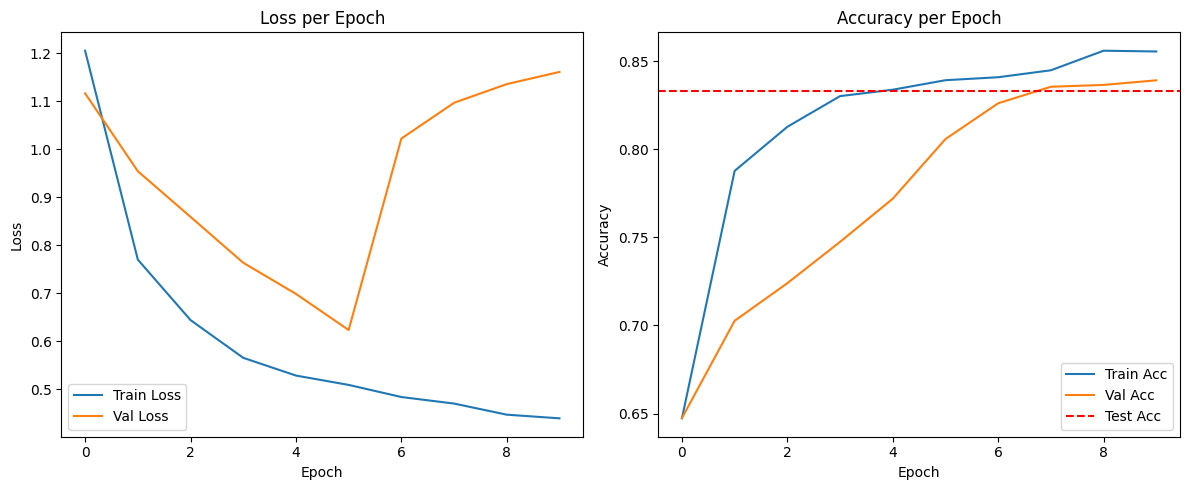

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.axhline(y=final_test_acc, color='r', linestyle='--', label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


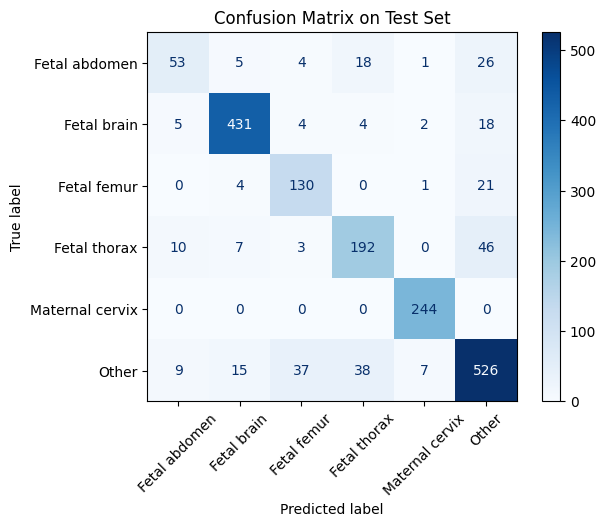

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [22]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

Classification Report:

                 precision    recall  f1-score   support

  Fetal abdomen       0.69      0.50      0.58       107
    Fetal brain       0.93      0.93      0.93       464
    Fetal femur       0.73      0.83      0.78       156
   Fetal thorax       0.76      0.74      0.75       258
Maternal cervix       0.96      1.00      0.98       244
          Other       0.83      0.83      0.83       632

       accuracy                           0.85      1861
      macro avg       0.82      0.81      0.81      1861
   weighted avg       0.84      0.85      0.84      1861



# GradCam

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2

In [25]:
image_tensor, label = test_dataset[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

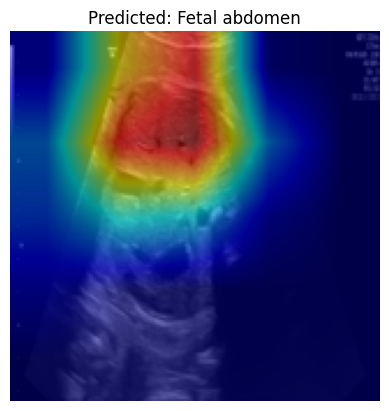

In [37]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Unfreeze model
for param in model.parameters():
    param.requires_grad = True

# Select the convolutional layer
target_layers = [model._blocks[-1]]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

# Choose a test image
image_tensor, label = test_dataset[0]
input_tensor = image_tensor.unsqueeze(0).to(device)

# model prediction
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Generate Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
grayscale_cam = grayscale_cam[0, :]  

# Convert image tensor to numpy for visualization
img = image_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
img = (img * 0.5) + 0.5 

# Create and show heatmap
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Predicted: {train_dataset.classes[pred_class]}")
plt.axis('off')
plt.show()